# Custom ES for optimizing RVCGP

- [Tournament selection](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutGaussian)
- [Arithmetic (blend) crossover](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutGaussian)
- [Gaussian mutation](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutGaussian)

First let's define environment

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tengp
import numpy as np
from gpbenchmarks import get_data
from sklearn.metrics import mean_squared_error
import random


def pdivide(x, y):
    return np.divide(x, y, out=np.copy(x), where=x!=0)

def plog(x, _):
    return np.log(x, out=np.copy(x), where=x>0)

def psin(x, _):
    return np.sin(x)

def pcos(x, _):
    return np.cos(x)

def pow2(x):
    return x**2

def pow3(x):
    return x**3


funset = tengp.FunctionSet()
funset.add(np.add, 2)
funset.add(np.subtract, 2)
funset.add(np.multiply, 2)
funset.add(pdivide, 2)

X, y = get_data('nguyenf4', 20, -1, 1)
X = np.c_[np.ones(len(X)), X]

rv_params = tengp.Parameters(2, 1, 1, 10, funset, real_valued=True)
params = tengp.Parameters(2, 1, 1, 10, funset, real_valued=False)

builder = tengp.individual.IndividualBuilder(rv_params)
bounds = builder.create().bounds[:]
genotypes = []

In [87]:
def clip(rv_genes, bounds):
    clipped = []
    for gene, bound in zip(rv_genes, bounds):
        if gene < 0:
            clipped.append(0)
        elif gene > bound:
            clipped.append(bound)
        else:
            clipped.append(gene)
    return clipped

def cost_function(rv_genes):
    individual = tengp.individual.NPIndividual(clip(rv_genes, bounds), bounds, rv_params)
    
    pred = individual.transform(X)
    
    try:
        out = mean_squared_error(pred, y)
    except ValueError:
        out = np.inf
        
 #   genotypes.append((scaled, out))
    return out

In [158]:
def plot_results(outs):
    costs = np.array(outs)
    print('mean:', np.mean(costs))
    print('median:', np.median(costs))
    print('variance:',np.var(costs))
    print('min:', np.min(costs))
    sns.distplot(costs);

Set up a simple base line. Classic CGP, simple ES, point mutation

In [160]:
random.seed(42)
simple_es_results = []
for i in range(100):
    print(i, end=', ')
    out = tengp.simple_es(X, y, mean_squared_error, params, mutation='point')
    simple_es_results.append(out)

0, 

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/jarino/dev/tensor-cgp/tengp/individual.py:152: RuntimeWarning: invalid value encountered in multiply
  current_node.value = current_node.fun(*values)


1, 2, 

/home/jarino/dev/tensor-cgp/tengp/individual.py:152: RuntimeWarning: invalid value encountered in add
  current_node.value = current_node.fun(*values)
/home/jarino/dev/tensor-cgp/tengp/individual.py:152: RuntimeWarning: invalid value encountered in subtract
  current_node.value = current_node.fun(*values)


3, 4, 5, 6, 

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

mean: 0.0900826103326
median: 0.0409660644493
variance: 0.0189638168103
min: 4.16482350474e-33


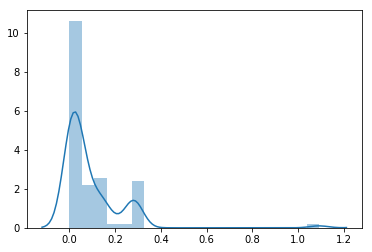

In [161]:
plot_results([x[0].fitness for x in simple_es_results])

First of all, let's try a really dumb hillclimber. It just randomly picks a gene and randomly changes its value.

In [147]:
random.seed(42)

indices = list(range(len(bounds)))
res = []

for trial in range(100):
    print(trial, end=', ')
    
    population = [Individual([random.uniform(0, b) for b in bounds]) for _ in range(5)]

    # evaluated the first population
    for individual in population:
        individual.fitness = cost_function(individual.genes)

    #print('first best individual', min(population, key=lambda x: x.fitness))

    n_evals = 0

    while n_evals < 5000:
        parent = min(population, key=lambda x: x.fitness)

        population = []

        # generate new population by randomly changing gene:
        for _ in range(4):
            index = random.choice(indices)

            new_genes = parent.genes[:]

            new_genes[index] = random.uniform(0, bounds[index])

            individual = Individual(new_genes)
            individual.fitness = cost_function(new_genes)
            n_evals += 1

            population.append(individual)

        population += [parent]
    res.append(sorted(population, key=lambda x: x.fitness)[0])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

In [148]:
costs = np.array([x.fitness for x in res])

In [149]:
print(np.mean(costs))
print(np.median(costs))
print(np.var(costs))
print(np.min(costs))

0.50452705612
0.203870773618
0.163916031454
0.0524146342587


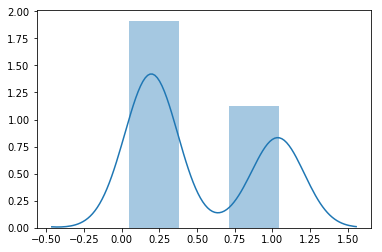

In [150]:
sns.distplot(costs)

Since we are working in real-valued domain, we can use method like L-BFGS-B for fine tuning the results. Let's apply L-BFGS-B algorithm to final individuals of previous run and see, whether we can achieve improvement.

In [145]:
from scipy.optimize import minimize

opt_results = []
for index, individual in enumerate(res):
    print(index, end=', ')
    opt_res = minimize(cost_function, individual.genes, method='L-BFGS-B', bounds=[(0, b) for b in bounds])#, options={'eps': 1})
    opt_results.append(opt_res.fun)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

0.67837079052
1.04046198617
0.252886379842
0.0235467799774


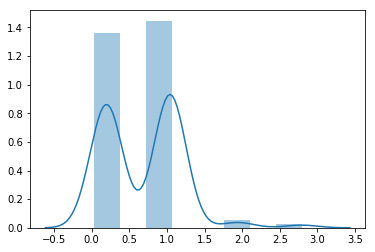

Well shit, no actuall improvement was achieved.

In [113]:
class Individual():
    def __init__(self, genes):
        self.genes = genes
        self.fitness = None
        
    def __repr__(self):
        return f'Ind: {self.fitness}'

Hyperparameters

In [34]:
POPULATION_SIZE = 50

Create the initial population and evaluate it

In [164]:
from array import array
from deap import creator, base, tools, cma, algorithms

creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', array, typecode='f', fitness=creator.FitnessMin)

In [182]:
import math

def bound(x, a, b):
    return a + (b - a) * ( 1 - np.cos(np.pi * x/10))/2

def scale_a(x, a, b):
    return a + (b - a) * x / 10

def scale_b(x, a, b):
    return a + (b - a) * (x/10)**2

def scale_c(x, a, b):
    return a *(b/a)**(x/10)

def cost_function_cma(rv_genes):
    bounded = bound(np.array(rv_genes), 0, 10)   
    scaled = [scale_a(x, 0, b) for x, b in zip(bounded, bounds)]
    individual = tengp.individual.NPIndividual(scaled, bounds, rv_params)
    
    pred = individual.transform(X)
    
    try:
        out = mean_squared_error(pred, y)
    except ValueError:
        out = np.inf
        
 #   genotypes.append((scaled, out))
    return (out, )

random.seed(42)

parent = creator.Individual([random.uniform(0, 10) for _ in bounds])
parent.fitness.values = toolbox.evaluate(parent)

strategy = cma.StrategyOnePlusLambda(parent=parent, sigma=5, lambda_=40)


toolbox = base.Toolbox()
toolbox.register('evaluate', cost_function_cma)
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)

pop, log = algorithms.eaGenerateUpdate(toolbox, ngen=250, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg    	min    
0  	40    	11.4372	1.19187
1  	40    	6.94479	1.8164 
2  	40    	10.1675	1.69753
3  	40    	22.5333	1.47089
4  	40    	15.8023	2.09826
5  	40    	9.92981	1.69846
6  	40    	14.0733	2.11034
7  	40    	12.0282	2.12345
8  	40    	7.56131	1.35628
9  	40    	11.242 	2.101  
10 	40    	5.77338	1.85864
11 	40    	5.36174	1.35783
12 	40    	8.893  	2.09985
13 	40    	8.26236	1.11981
14 	40    	5.44339	1.74102
15 	40    	3.90598	1.80442
16 	40    	5.29632	2.09917
17 	40    	4.59506	1.69591
18 	40    	3.7562 	1.30342
19 	40    	3.44428	1.71726
20 	40    	3.69995	1.24742
21 	40    	4.68887	1.24269
22 	40    	3.73307	1.15222
23 	40    	4.18993	1.18462
24 	40    	4.01135	1.04333
25 	40    	4.21436	1.04725
26 	40    	4.43642	1.08026
27 	40    	3.53551	1.0955 
28 	40    	4.02509	1.04602
29 	40    	4.24059	1.07625
30 	40    	3.42858	1.05745
31 	40    	3.03931	1.05982
32 	40    	2.44304	1.04861
33 	40    	2.9998 	1.04109
34 	40    	3.12176	1.0487 
35 	40    	2.11638	1.04244
3

In [178]:
cost_function_cma(hof[0])

(1.0404619516475269,)